In [ ]:
#If the cv2 module is not found, run that:
#!pip install opencv-python

## important if  running on Colab
switch under runtime the "Change runtime type" to a GPU support. This will speed up you calculations immensely

In [2]:
import sys,os
import numpy as np                     #main package for scientific computing with Python.
import pandas as pd                    #main data handling package
from matplotlib import image           #plot graphs in Python.
import matplotlib.pyplot as plt        #lazy plotting
import cv2                             #image opening

# Building and training a neural network

In this notebook, we are going to see and build the basic components of neural networks. We will first build from scratch a two layer neural network that we will then train to separate images from birds and images from dogs. The we will use Torch with a similar network and finally use Keras to build a sequential neural network with some advanced corrections

There are six components to artificial neurons. From left (input) to right (output). If we only consider numerical values these are:

1. Input nodes. Each input node is a real number
2. Connections with weight. Each connection that departs from the input node has a weight, which is also a real number.
3. Calculate a weighted sum: $y = \sum_{i=1}^{D} w_i*x_i$
4. Feed this sum into a transfer or activation function.
this can be idendity, but normally this is a treshold function. e.g. $\left\{\begin{matrix}
=0 \;\text{if}\; x\leq 0.5\\
=1 \;\text{if}\; x>0.5
\end{matrix}\right.$<br>
Which however is not smooth, so alternatively a continous (sigmoid) function such as the logistic function is an alternative (see below)
5. output node of this chain
6. A perceptron is sometimes added to this, often this is called a bias, Which is an input node with a fixed value

With the percepton the treshold is easier defined, meaning that the transfer function can be switching at zero. (sometimes called ReLU Rectifying Linear Unit) There are other variants, but we will talk about them in the Keras section.

Text(0.5, 1.0, 'One logistic function')

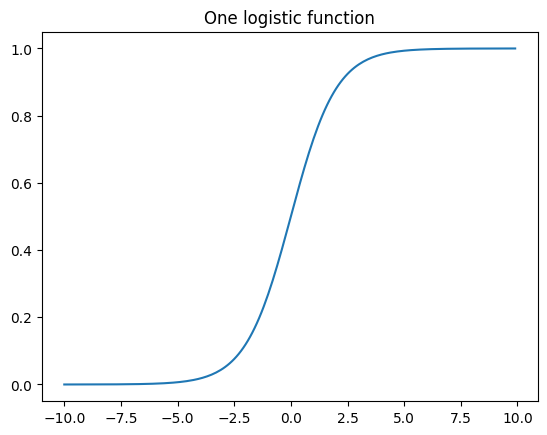

In [3]:
x=np.arange(-10,10,0.1);y=np.exp(x)/(1 + np.exp(x))
fig,ax=plt.subplots();plt.plot(x,y);ax.set_title('One logistic function')

# Data Loading
Now, we load the data that we will need for the NN

In [4]:
import sys
if "google.colab" in sys.modules:
    path_to_files = os.sep.join([os.getcwd(), "Bern02", "Labs", "Neural_Networks", "train"])
    !git clone https://github.com/luchem/Bern02.git --depth=1
else:
    path_to_files = os.sep.join([os.getcwd(), "train"])

Cloning into 'Bern02'...
remote: Enumerating objects: 2456, done.
remote: Counting objects: 100% (2456/2456), done.
remote: Compressing objects: 100% (2455/2455), done.
remote: Total 2456 (delta 0), reused 2447 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (2456/2456), 17.74 MiB | 20.34 MiB/s, done.


In [5]:
#We create two empty lists to store the data (the images) and the labels (0 if bird, 1 if dog)
data=[]
labels=[]
image_size=28
#We now load the data into the notebook from the folder on your computer
for filename in os.listdir(os.sep.join([path_to_files,'bird'])):
    labels.append(0)
    data.append(cv2.resize(image.imread(os.sep.join([path_to_files,'bird',filename])),dsize=(image_size,image_size)))
for filename in os.listdir(os.sep.join([path_to_files,'dog'])):
    labels.append(1)
    data.append(cv2.resize(image.imread(os.sep.join([path_to_files,'dog',filename])),dsize=(image_size,image_size)))
data=np.array(data)
labels=np.array(labels)

Questions:
How many data files do we have in total?<br>

- 2400 files in total: 1200 birds and 1200 dogs


Lets split this data into a training and testing dataset. While there are specific selectors for this we simply use a permutation of the index.

In [ ]:
print("Total images:", len(data))
print("Bird images:", np.sum(labels == 0))
print("Dog images:", np.sum(labels == 1))

Total images: 2400
Bird images: 1200
Dog images: 1200


In [ ]:
np.random.seed(0)
idx=np.random.permutation(len(labels))
idx_train=idx[0:2000]
idx_test=idx[2001:2401]
train_x=data[idx_train]
test_x=data[idx_test]
train_y=labels[idx_train].reshape(1,-1)
test_y=labels[idx_test].reshape(1,-1)

* What is the size of the images?

  32 x 32 (w x h), 3 color channels

* Does the size matter?

  Yes, it is important for neural network.

  Smaller size: fewer features, faster training, less memory needed but may lose details and maybe harder to distinguish bird vs. dog.

  Larger size: more features, higher capacity needed to capture details. But training is slower and requires more data (risk of overfitting if dataset is small)

# Data Inspection

the shape of the image is:
(28, 28, 3)


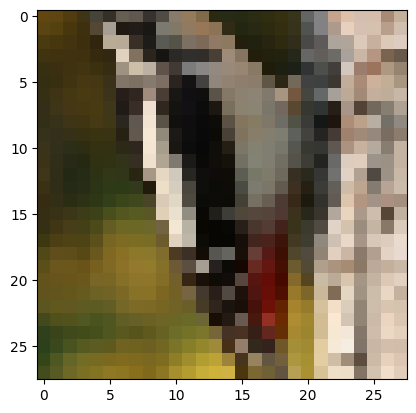

In [ ]:
print('the shape of the image is:')
print(train_x[0].shape)
plt.imshow(train_x[4])

# Data shaping

To avoid some divergence, we normalize the intensity of each pixels and flatten it. The flattening is a simplification to not have to deal with the dimensions. As we will be connecting every pixel the actual positions do not matter. This will be different for convolutional networks.

In [ ]:
# we use a single dimension layer, so flattening the matrix
train_x_flatten=train_x.reshape(train_x.shape[0],-1).T
test_x_flatten=test_x.reshape(test_x.shape[0],-1).T
# all values must be "normalized" meaning between 0 and 1
train_x_flatten=train_x_flatten/255
test_x_flatten=test_x_flatten/255

We will build a neural network with 2 layers
First we start by building the neural net. For this we we initialize the weights and biases for each layer.

# Neuronal net building

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
    """
    n_x -- size of input layer;
    n_h -- size of hidden layer;
    n_y -- size of output layer
    Returns:
    parameters -- python dictionary containing your parameters:
    """
    W1 = np.random.randn(n_h, n_x) * 0.01 #W1 -- weight matrix of shape (n_h, n_x)
    b1 = np.zeros((n_h, 1))               #b1 -- bias vector of shape (n_h, 1)
    W2 = np.random.randn(n_y, n_h) * 0.01 #W2 -- weight matrix of shape (n_y, n_h)
    b2 = np.zeros((n_y, 1))               #b2 -- bias vector of shape (n_y, 1)
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

We now code the forward propagation through  (from the input to the output (left to right)

In [ ]:
def linear_forward(Input_Matrix, Weights, bias):
    """
    function to calculate the combination of Input, weights and bias
    forward propagation.
    Returns: Output_Matrix, (Input_Matrix, Weights, bias)
    """
    Output_Matrix = np.dot(Weights, Input_Matrix) + bias
    cache = (Input_Matrix, Weights, bias)
    return Output_Matrix, cache
def relu(Z):# forward activation (rectification function)
    return np.maximum(np.zeros(Z.shape),Z),Z
def sigmoid(Z): # forward activation (smooth rectification)
    return 1/(1+np.exp(-Z)),Z
def linear_activation_forward(Input_Matrix, Weights, bias, activation_method):
    """
    Input_Matrix: size of previous layer
    Weights: numpy array of shape (size of current layer, size of previous layer)
    bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer "sigmoid" or "relu"
    Returns: Output_Matrix, (linear_cache, activation_cache)
    """
    if activation_method == "sigmoid":
        Z, linear_cache = linear_forward(Input_Matrix, Weights, bias)
        Output_Matrix, activation_cache = sigmoid(Z)
    elif activation_method == "relu":
        Z, linear_cache = linear_forward(Input_Matrix, Weights, bias)
        Output_Matrix, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return Output_Matrix, cache

In [ ]:
def compute_cost(Calculated_classiciation,True_classification):
    """Calculate the cost=error of the current prediction"""
    m = True_classification.shape[1] #get size of vector
    a=np.multiply(np.log(Calculated_classiciation),True_classification)
    b=np.multiply(np.log(1-Calculated_classiciation),1-True_classification)
    cost =  (-1./m)*np.sum(a+b)
    cost = np.squeeze(cost)# To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    return cost

1. In the forward propagate stage, the data flows through the network to get the outputs.
2. Then we use the loss function to calculate the total error.
3. Then we use a backward propagation algorithm to calculate the gradient of the loss function with respect to each weight and bias (without having to actualy calculate differentials = more efficient)
This gradient helps us to predict how we should adjust the parameter of the weights more efficiently

In [ ]:
def linear_backward(dCost, cache):
    """linear backward step
    dCost=cost gradient, cache -- from forward step (Input_Matrix, Weights, bias)

    Returns:
    dInput -- Gradient of the cost with respect to the activation
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    Input_Matrix, Weights, bias = cache
    m = Input_Matrix.shape[1]
    dWeights = (1./m)*np.dot(dCost, Input_Matrix.T)
    dbias = (1./m)*np.sum(dCost, axis=1, keepdims=True)
    dActivation = np.dot(Weights.T, dCost)
    return dActivation, dWeights, dbias

def relu_backward(dA, activation_cache):
    return np.multiply(dA,np.heaviside(activation_cache,0))
def sigmoid_backward(dA,activation_cache):
    return np.multiply(dA,np.multiply(sigmoid(activation_cache)[0],np.ones(activation_cache.shape)-sigmoid(activation_cache)[0]))

def linear_activation_backward(dCost, cache, activation_method):
    """Complete backward step:
    dCost -- cost gradient;
    cache -- (linear_cache, activation_cache);
    activation -- the method as string: "sigmoid" or "relu"

    Returns:
    dActivation, dCost in respect to activation
    dWeights, dCost in respect to weights
    dbias, dCost in respect to bias
    """
    linear_cache, activation_cache = cache

    if activation_method == "relu":
        dZ = relu_backward(dCost, activation_cache)
        dActivation, dWeights, dbias = linear_backward(dZ, linear_cache)
    elif activation_method == "sigmoid":
        dZ = sigmoid_backward(dCost, activation_cache)
        dActivation, dWeights, dbias = linear_backward(dZ, linear_cache)
    return dActivation, dWeights, dbias


In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    """ Update parameters using gradient descent
    Arguments: parameters (dict), gradients (dict), learning_rate = L_model_backward
    Returns:
    updated parameters (dict)
    """
    L = int(len(parameters.keys())/2) # number of layers in the neural network
    for l in range(L):
        parameters["W%i"%(l+1)] -= learning_rate * gradients["dW%i"%(l+1)]
        parameters["b%i"%(l+1)] -= learning_rate * gradients["db%i"%(l+1)]
    return parameters

In [ ]:
def predictions(X,Y,parameters):
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    A1, cache1 = linear_activation_forward(X, W1, b1, activation_method='relu')
    A2, cache2 = linear_activation_forward(A1, W2, b2, activation_method='sigmoid')
    Z=np.floor(A2+0.5).astype(int)
    return np.sum((Z==Y).astype(int))/len(Y.T)

In [ ]:
### CONSTANTS DEFINING THE MODEL ####
n_x = image_size*image_size*3#3072     # num_px * num_px * 3
n_h = 128  #we use these number nodes
n_y = 1 #layer thickness
layers_dims = (n_x, n_h, n_y)

In [ ]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.05, num_iterations = 500, print_cost_every=None):
    """LINEAR->RELU->LINEAR->SIGMOID.
    X Image_input of shape (n_x, number of examples)
    Y Vector with true "labels" (containing 0 if bird, 1 if dog)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost_every -- printing iteration
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    accuracy_train=[]
    accuracy_test=[]
    (n_x, n_h, n_y) = layers_dims
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):# Loop (gradient descent)

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID.
        A1, cache1 = linear_activation_forward(X, parameters["W1"], parameters["b1"], activation_method='relu')
        A2, cache2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], activation_method='sigmoid')
        # Compute cost
        cost = compute_cost(A2, Y)
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        # Backward propagation. (calculate gradients)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation_method="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation_method="relu")
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        # Update parameters.
        learning_rate*=0.999
        parameters = update_parameters(parameters, grads, learning_rate)
        # Print the cost every 20 training example
        if print_cost_every is None:
            continue
        else:
            if i % print_cost_every == 0:
                accur=predictions(train_x_flatten,train_y,parameters)
                accur2=predictions(test_x_flatten,test_y,parameters)
                accuracy_train.append(accur)
                accuracy_test.append(accur2)
                costs.append(cost)
                print("Train accuracy after iteration {}: {}".format(i,accur))
                print("Test accuracy after iteration {}: {}".format(i,accur2))
    accur=predictions(train_x_flatten,train_y,parameters)
    accur2=predictions(test_x_flatten,test_y,parameters)
    accuracy_train.append(accur)
    accuracy_test.append(accur2)
    costs.append(cost)
    if print_cost_every is None:
        return parameters,accuracy_train,accuracy_test
    else:
        return parameters,accuracy_train,accuracy_test,costs

Train accuracy after iteration 0: 0.504
Test accuracy after iteration 0: 0.47117794486215536
Train accuracy after iteration 100: 0.598
Test accuracy after iteration 100: 0.6265664160401002
Train accuracy after iteration 200: 0.607
Test accuracy after iteration 200: 0.6215538847117794
Train accuracy after iteration 300: 0.6225
Test accuracy after iteration 300: 0.6265664160401002
Train accuracy after iteration 400: 0.637
Test accuracy after iteration 400: 0.606516290726817
Train accuracy after iteration 500: 0.644
Test accuracy after iteration 500: 0.606516290726817
Train accuracy after iteration 600: 0.6575
Test accuracy after iteration 600: 0.6090225563909775
Train accuracy after iteration 700: 0.6515
Test accuracy after iteration 700: 0.5964912280701754
Train accuracy after iteration 800: 0.6665
Test accuracy after iteration 800: 0.5989974937343359
Train accuracy after iteration 900: 0.6695
Test accuracy after iteration 900: 0.6015037593984962
Train accuracy after iteration 1000: 0.6

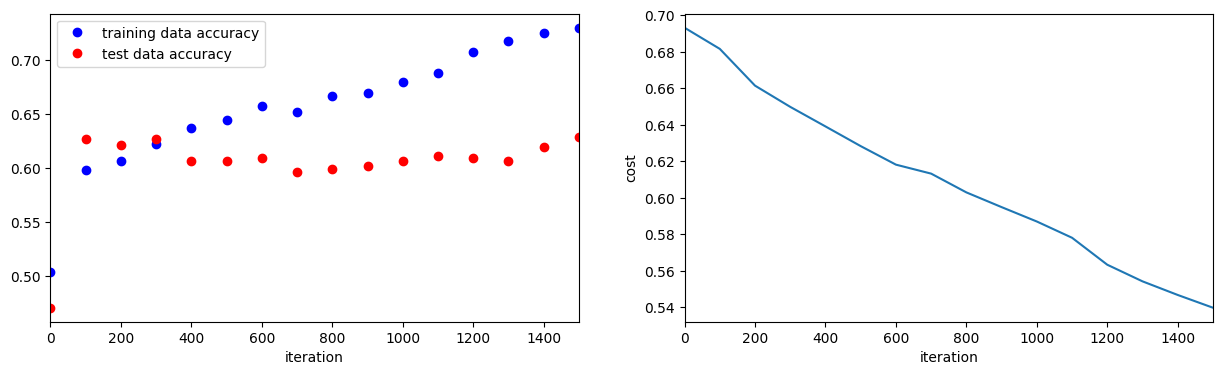

In [ ]:
if 1:#activate to run
    n_iter=1500
    print_cost_every=100
    parameters,accuracy_train,accuracy_test,costs = two_layer_model(train_x_flatten, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = n_iter, print_cost_every=print_cost_every)

    #plot the output
    fig,ax=plt.subplots(1,2,figsize=(15,4))
    x=np.arange(0,n_iter+print_cost_every,print_cost_every)
    ax[1].plot(x,costs)
    ax[1].set_ylabel('cost')
    ax[0].plot(x,np.squeeze(accuracy_train),'bo',label='training data accuracy')
    ax[0].plot(x,np.squeeze(accuracy_test),'ro',label='test data accuracy')
    ax[0].set_xlabel('iteration');ax[1].set_xlabel('iteration')
    ax[0].set_xlim(0,n_iter);ax[1].set_xlim(0,n_iter)
    ax[0].legend()

We see that first, both the training and test accuracies are getting better. However, when we keep on, we see the training accuracy incresing, but the test accuracy decay. We are overfitting the training data set, $\textit{i.e.}$ we create a NN that is really good on the training data, but that cannot generalize to other data. (pretty much after 100 images)

## Task
* express what does this mean and what could you do to improve that?

  This is overfitting.

  What could be done to improve?

    ** Data manipulation/ data-level fixes

    - Get more labeled data
    - Data augmentation: random flips, rotation, crops,...
    - Reduce image size (if images contain redundant detail): reduce input dimensionally -> lower capacity needed -> less overfitting (trade-off: maybe lose signal).

    ** Regularization

    - Dropout on the hidden layer to force redundancy and escape local minimums.
    - Reduce model capacity: decrease hidden neurons (128 -> 64 -> or 32) or ferwer layers.
    - Early stopping: monitor validation loss (or test accuracy on a hold-on dataset) and stop when it stops improving.This directly prevents overtraining past the point of best generalization

    ** Alternative models

    - CNNs

* change the image size (a little) and see how the quality changes

Train accuracy after iteration 0: 0.485
Test accuracy after iteration 0: 0.47619047619047616
Train accuracy after iteration 100: 0.5905
Test accuracy after iteration 100: 0.631578947368421
Train accuracy after iteration 200: 0.603
Test accuracy after iteration 200: 0.606516290726817
Train accuracy after iteration 300: 0.6215
Test accuracy after iteration 300: 0.6090225563909775
Train accuracy after iteration 400: 0.637
Test accuracy after iteration 400: 0.6115288220551378
Train accuracy after iteration 500: 0.6475
Test accuracy after iteration 500: 0.6140350877192983
Train accuracy after iteration 600: 0.6555
Test accuracy after iteration 600: 0.6040100250626567
Train accuracy after iteration 700: 0.6615
Test accuracy after iteration 700: 0.6040100250626567
Train accuracy after iteration 800: 0.6685
Test accuracy after iteration 800: 0.6040100250626567
Train accuracy after iteration 900: 0.6825
Test accuracy after iteration 900: 0.6215538847117794
Train accuracy after iteration 1000: 0

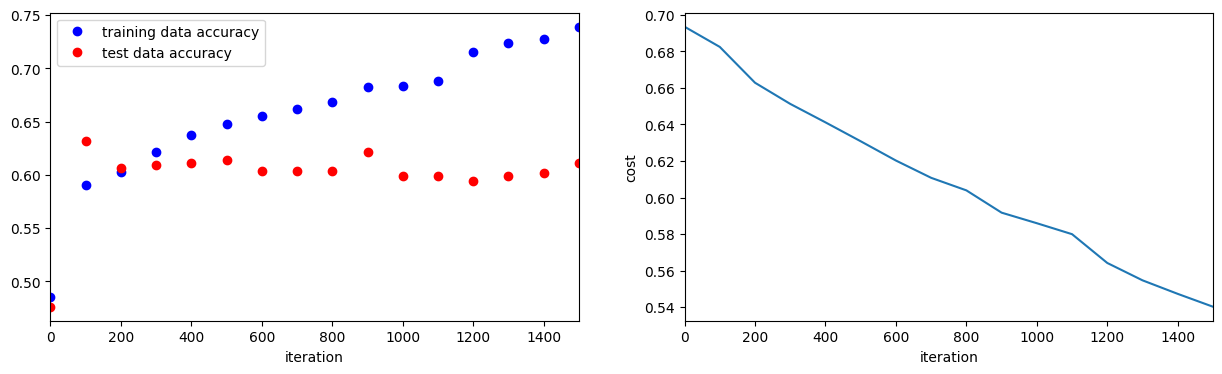

In [ ]:
# image_size=28
if 1:#activate to run
    n_iter=1500
    print_cost_every=100
    parameters,accuracy_train,accuracy_test,costs = two_layer_model(train_x_flatten, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = n_iter, print_cost_every=print_cost_every)

    #plot the output
    fig,ax=plt.subplots(1,2,figsize=(15,4))
    x=np.arange(0,n_iter+print_cost_every,print_cost_every)
    ax[1].plot(x,costs)
    ax[1].set_ylabel('cost')
    ax[0].plot(x,np.squeeze(accuracy_train),'bo',label='training data accuracy')
    ax[0].plot(x,np.squeeze(accuracy_test),'ro',label='test data accuracy')
    ax[0].set_xlabel('iteration');ax[1].set_xlabel('iteration')
    ax[0].set_xlim(0,n_iter);ax[1].set_xlim(0,n_iter)
    ax[0].legend()

Reducing the image size from 32 to 28 leads to increase in test data accuracy a little.

# 2. Convolutional Bird Dog Modelling with Keras
A specific kind of deep neural networks is the convolutional network. (often referred to as CNN or ConvNet)
It's a deep, **feed-forward only** artificial neural network also called multi-layer perceptrons(MLPs).
CNNs are inspired by the biological visual cortex.
Convolutional neural networks performe a lot better than traditional computer vision.
As before we connect the Input layer to a convolution layer. As before each layer is computing a dot product between their weights and the input. Each computation leads to extraction of a feature map from the input image.

1. In Convolutional NN we perform very efficient calculations (Convolutions) of the input with a small matrix (here 3x3) that is effectively sliding over the image and represents of these convolutions with a single number: done by:
    <br>**bird_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,32,3),padding='same'))**
2. Then we have our transfer function (as before aReLU or Sigmodial, here we use a "leaky Relu" that has some suppression effect
    <br>**bird_model.add(LeakyReLU(alpha=0.1))**
3. We use a technique call maxpooling that is one of the techniques reducing the dimension of the image. This often is useful to reduce oversampling. It takes the max values of a smaller section of the image that is currently covered by the kernel
<br>**bird_model.add(MaxPooling2D((2, 2),padding='same'))**
<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" width="200">

4. We use a classic optimizer (given to Keras and then run an optimization over multiple "epochs)
5. Epoch: an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation. The model is updated each time a batch is processed, which means that it can be updated multiple times during one epoch. If batch_size is set equal to the length of x, then the model will be updated once per epoch.


### Plot the "LeakyReLU"

Text(-0.75, 0, 'Leak=0.1*x')

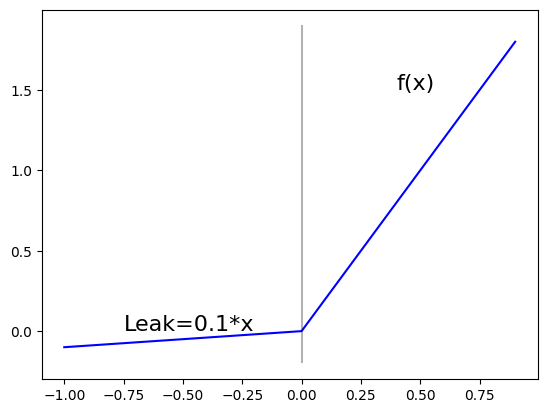

In [ ]:
#Leaky Rectified Linear Unit
x=np.arange(-1,1,0.1);y=2*x;y[x<0]=0.1*x[x<0]
fig,ax=plt.subplots();ax.plot(x,y,'blue');ax.plot([0,0],ax.get_ylim(),'black',alpha=0.3)
ax.text(x=0.4,y=1.5,s='f(x)',fontsize=16);ax.text(x=-0.75,y=0,s='Leak=0.1*x',fontsize=16)

In [ ]:
#We create two empty lists to store the data (the images) and the labels (0 if bird, 1 if dog)
data=[]
labels=[]
image_size=32
#We now load the data into the notebook from the folder on your computer
for filename in os.listdir(os.sep.join([path_to_files,'bird'])):
    labels.append(0)
    data.append(cv2.resize(image.imread(os.sep.join([path_to_files,'bird',filename])),dsize=(image_size,image_size)))
for filename in os.listdir(os.sep.join([path_to_files,'dog'])):
    labels.append(1)
    data.append(cv2.resize(image.imread(os.sep.join([path_to_files,'dog',filename])),dsize=(image_size,image_size)))
data=np.array(data)
labels=np.array(labels)

In [ ]:
np.random.seed(0)
idx=np.random.permutation(len(labels))
idx_train=idx[0:2200]
idx_test=idx[2201:2401]
train_x=data[idx_train]
test_x=data[idx_test]
train_y=labels[idx_train].reshape(1,-1)
test_y=labels[idx_test].reshape(1,-1)

In [6]:
import sys
#!{sys.executable} -m pip install keras, tensorflow
import numpy as np
import keras

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_x=data[idx_train]
test_x=data[idx_test]
train_y=labels[idx_train]#.reshape(1,-1)
test_y=labels[idx_test]#.reshape(1,-1)
print('Training data shape : ', train_x.shape, train_y.shape)
print('Testing data shape : ', test_x.shape, test_y.shape)

Training data shape :  (2200, 32, 32, 3) (2200,)
Testing data shape :  (199, 32, 32, 3) (199,)


In [ ]:
classes = np.unique(train_y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


Text(0.5, 1.0, 'Dog')

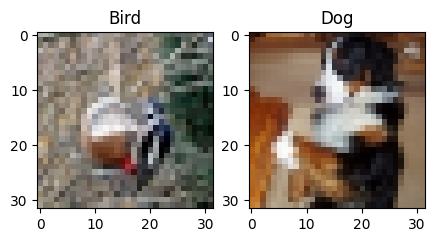

In [ ]:
plt.figure(figsize=[5,5])
def naming(key):
    if key==1:return 'Dog'
    elif key==0: return 'Bird'
    else: raise
# Display the first image in training data
plt.subplot(121)
plt.imshow(train_x[101,:,:,:])
plt.title("{}".format(naming(train_y[101])))
# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_x[101,:,:,:])
plt.title("{}".format(naming(test_y[101])))

In [ ]:
train_x = train_x.reshape(-1, 32,32, 3)
test_x = test_x.reshape(-1, 32,32, 3)
print('Datashape: {}\nTestshape:{}'.format(train_x.shape, test_x.shape))
# Normalization needed
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x = train_x / 255.
test_x = test_x / 255.

Datashape: (2200, 32, 32, 3)
Testshape:(199, 32, 32, 3)


In [ ]:
train_y_one_hot = to_categorical(train_y)
test_y_one_hot = to_categorical(test_y)
# Display the change for category label using one-hot encoding
print('Original label:', train_y[0])
print('After conversion to one-hot:', train_y_one_hot[0])

Original label: 1
After conversion to one-hot: [0. 1.]


In [ ]:
#This would be an automatic way to split the data
train_x,valid_x,train_label,valid_label = train_test_split(train_x, train_y_one_hot, test_size=0.2, random_state=13)
# test the shape
train_x.shape,valid_x.shape,train_label.shape,valid_label.shape

((1760, 32, 32, 3), (440, 32, 32, 3), (1760, 2), (440, 2))

In [ ]:
# Set modelling parameter
batch_size = 50 # load this many
epochs = 30     # Total throughput
num_classes = 2 # Categories

In [ ]:
# Set modelling parameter
batch_size = 50 # load this many
epochs = 50     # Total throughput
num_classes = 2 # Categories

bird_model = Sequential()
bird_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,32,3),padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D((2, 2),padding='same'))
bird_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
bird_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
bird_model.add(Flatten())
bird_model.add(Dense(128, activation='linear'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(Dense(num_classes, activation='softmax'))
bird_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
bird_model.summary()
bird_train = bird_model.fit(train_x, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_x, valid_label))
bird_model.save("bird_model_no_dropout.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,778 (1.36 MB)

 Trainable params: 355,778 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.5332 - loss: 0.7042 - val_accuracy: 0.5568 - val_loss: 0.6744
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5956 - loss: 0.6571 - val_accuracy: 0.5909 - val_loss: 0.6428
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6818 - loss: 0.6041 - val_accuracy: 0.6386 - val_loss: 0.6011
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6720 - loss: 0.5798 - val_accuracy: 0.7273 - val_loss: 0.5623
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7420 - loss: 0.5219 - val_accuracy: 0.7114 - val_loss: 0.5592
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7710 - loss: 0.4811 - val_accuracy: 0.6523 - val_loss: 0.6816
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7932 - loss: 0.4337 - val_accuracy: 0.7295 - val_loss: 0.5883
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8636 - loss: 0.3228 - val_accuracy: 0.7250 - val_loss

Test loss: 1.324370265007019
Test accuracy: 0.7889447212219238


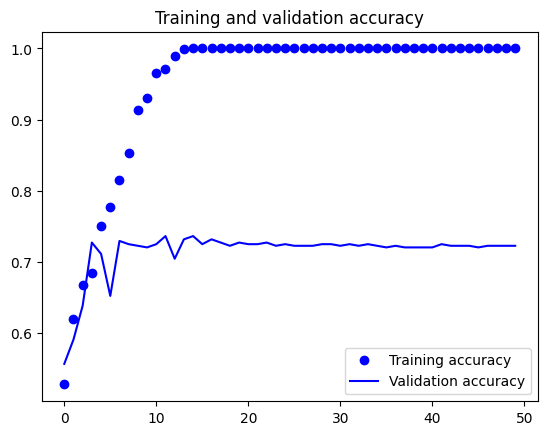

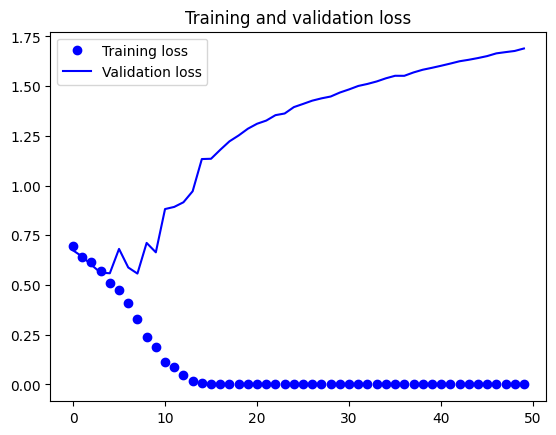

In [ ]:
test_eval = bird_model.evaluate(test_x, test_y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = bird_train.history['accuracy']
val_accuracy = bird_train.history['val_accuracy']
loss = bird_train.history['loss']
val_loss = bird_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Fix overfitting by freezing a random number of nodes at each step


In [ ]:
# Set modelling parameter
batch_size = 50 # load this many
epochs = 50     # Total throughput
num_classes = 2 # Categories

bird_model = Sequential()
bird_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,32,3),padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D((2, 2),padding='same'))
bird_model.add(Dropout(0.25))
bird_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
bird_model.add(Dropout(0.25))
bird_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
bird_model.add(Dropout(0.5))
bird_model.add(Flatten())
bird_model.add(Dense(128, activation='linear'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(Dropout(0.3))
bird_model.add(Dense(num_classes, activation='softmax'))
bird_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
bird_model.summary()
bird_train = bird_model.fit(train_x, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_x, valid_label))
bird_model.save("bird_model_with_dropout.h5")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,778 (1.36 MB)

 Trainable params: 355,778 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.4912 - loss: 0.7395 - val_accuracy: 0.5114 - val_loss: 0.6909
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5329 - loss: 0.6909 - val_accuracy: 0.5455 - val_loss: 0.6842
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5862 - loss: 0.6670 - val_accuracy: 0.5045 - val_loss: 0.6807
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5648 - loss: 0.6658 - val_accuracy: 0.6114 - val_loss: 0.6412
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6312 - loss: 0.6417 - val_accuracy: 0.5818 - val_loss: 0.6451
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6392 - loss: 0.6068 - val_accuracy: 0.6795 - val_loss: 0.6065
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6609 - loss: 0.5871 - val_accuracy: 0.6409 - val_loss: 0.6196
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6546 - loss: 0.6021 - val_accuracy: 0.6727 - val_los

Test loss: 0.5885589122772217
Test accuracy: 0.8190954923629761


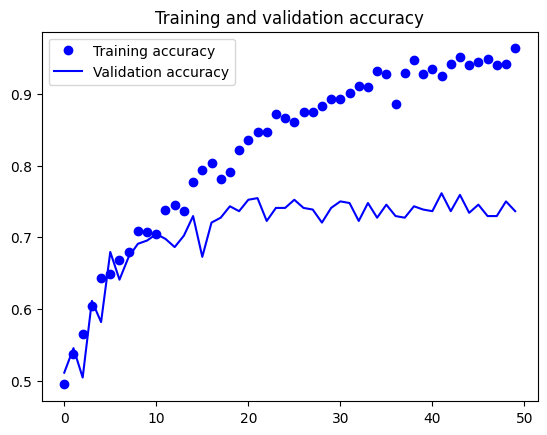

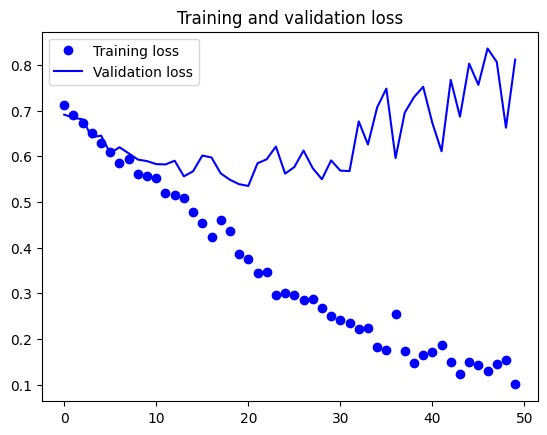

In [ ]:
test_eval = bird_model.evaluate(test_x, test_y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = bird_train.history['accuracy']
val_accuracy = bird_train.history['val_accuracy']
loss = bird_train.history['loss']
val_loss = bird_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

See how the validation accuracy follows the training data much longer and how we achieve a much lower loss through the partial freeze? This is due to that bad training images not influence the formation as strong, as always some of the nodes are locked = made resilliant

## Test with virgin data

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Found 163 correct recognitions (of 199 total)


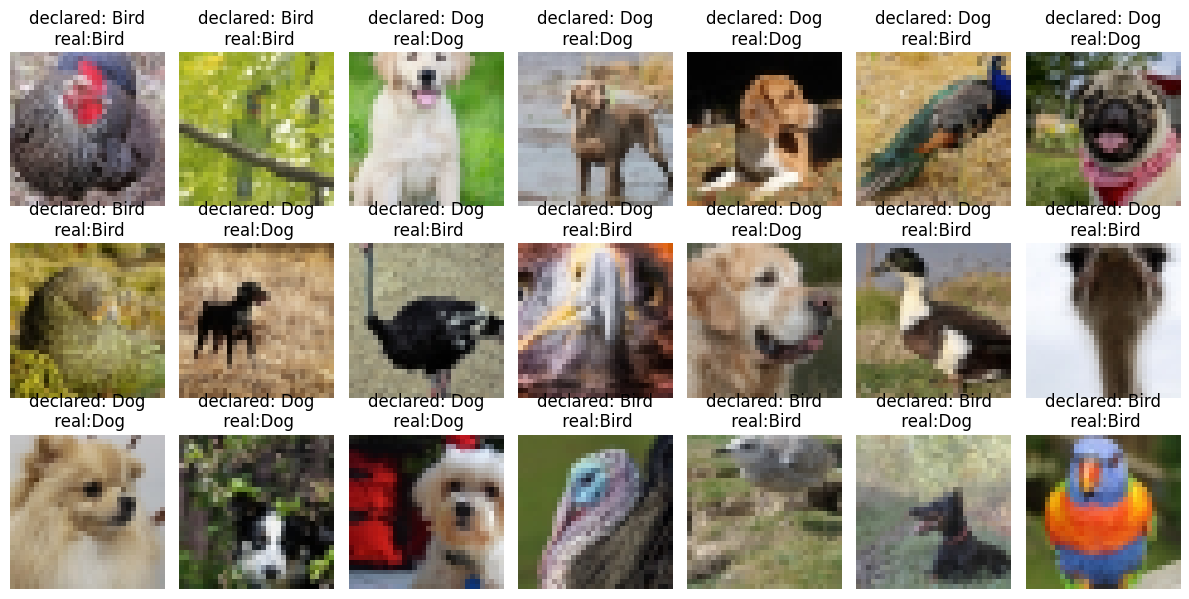

In [ ]:
def naming(key):
    if key==1:return 'Dog'
    elif key==0: return 'Bird'
    else: raise
predicted_classes = bird_model.predict(test_x)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_x.shape
correct = np.where(predicted_classes==test_y)[0]
print("Found %d correct recognitions (of %d total)"%(len(correct),len(test_y)))
fig,ax=plt.subplots(3,7,figsize=(12,6))
ax=ax.ravel()
for i in range(21):
    ax[i].imshow(test_x[i].reshape(32,32,3), interpolation='none')
    ax[i].set_title("declared: %s\n real:%s"%(naming(predicted_classes[i]),naming(test_y[i])))
    ax[i].axis('off')
fig.tight_layout()

## Task
* compare carefull the two models and identify what is the difference

  **Model 1: No dropout**
    - Conv2D #1: 32 filters, 3x3, LeakyLU
    - MaxPooling #1: 2x2, padding ="same"
    - Dropout #1: None
    ***
    - Conv2D #2: 64 filters, 3x3, LeakyLU
    - MaxPooling #2: 2x2, padding ="same"
    - Dropout #2: None
    ***
    - Conv2D #3: 128 filters, 3x3, LeakyLU
    - MaxPooling #3: 2x2, padding ="same"
    - Dropout #3: None
    ***
    - Flatten
    - Dense #1: 128 neurons, LeakyLU
    - Dropout #4: None
    - Output Dense: 2 neurons, softmax

  **Model 2: With Dropout**
    - Conv2D #1: 32 filters, 3x3, LeakyLU
    - MaxPooling #1: 2x2, padding ="same"
    - **Dropout #1: 0.25**. ie. the model randomly disables 25% of neurons -> regularization
    ***
    - Conv2D #2: 64 filters, 3x3, LeakyLU
    - MaxPooling #2: 2x2, padding ="same"
    - **Dropout #2: 0.25**. More regularization
    ***
    - Conv2D #3: 128 filters, 3x3, LeakyLU
    - MaxPooling #3: 2x2, padding ="same"
    - **Dropout #3: 0.5**. Stronger regularization at deeper layers
    ***
    - Flatten
    - Dense #1: 128 neurons, LeakyLU
    - **Dropout #4: 0.3**. Reduce overfitting in fully connected layer
    - Output Dense: 2 neurons, softmax


* Why do we use max pooling?

  Max pooling is a downsampling operation applied after convolution layers. It condense a large image into a smaller summary image

  - Retain important features:
    - Keep the maximum value in each pooling window
    - Preserces the most prominent features (like edges or textures) while discarding less important information.

  - Provides some location invariance, i.e. as long as there is a large value in one of the four pixels, the whole block register as a large value in the reduced image.


* Why do we use dropout?
  Dropout randomly "drops" a fraction of neurons during training.

  - Prevent overfitting: Without dropout, the network can memorize the training data, especially with small datasts. By dropping neurons, the netwrok is forced to learn more robust and distributed features.

  - Regularization: each forward pass is slightly different, making the network less reliant on specific neurons.

## Task
* use your webcam to take >15 photos of yourself. Show a series of emotions, but make sure that some are happy and some are sad (take my pictures in train/faces if you have no camera)
* prepare the data by slicing it close to your face and average the three color channels (use cmap='gray' for imshow after the averaging)
* create a vector that is categorizing your data (sad or happy)
* resample (the optimum slice) of your images to be 32x32 pixels using cv2 and normalize them by dividing with 255
* Create a Convolutional neural network with one or two hidden layers and train it on your data.
* Then extract the  weights with:<br>
  ```weights=face_model.layers[0].get_weights()[0]```<br>
  ```weights=weights.mean(axis=0).mean(axis=0).mean(axis=0)```<br>
* Normalize them and plot them.
* Where in the image lays the highest values (highest focus)? How does this change with your choice of size of the network?
* Check the prediction for few of your pictures with ```face_model.predict```
  

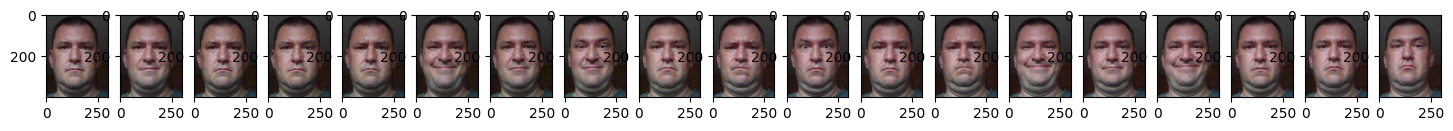

In [ ]:
from matplotlib import image
data=[]
list_of_files=os.listdir(os.sep.join([path_to_files,'faces']))
for filename in sorted(list_of_files):
    data.append(image.imread(os.sep.join([path_to_files,'faces',filename])))
axis_list=[]
fig,ax=plt.subplots(1,len(data),figsize=(18,8))
for i,img in enumerate(data):
    ax[i].imshow(img[200:600,500:800,:],cmap='gray')
happy=np.array([0,1,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0])
data=[cv2.resize(img[200:600,500:800,:].mean(axis=2)/255,dsize=(36,36)) for img in data]
data=np.array(data)
label=np.vstack((happy,np.negative(happy)+1)).T

In [ ]:
data[0].shape

(36, 36)

In [ ]:
# Set modelling parameter

epochs = 50     # Total throughput
num_classes = 2 # Categories

face_model = Sequential()
face_model.add(Conv2D(36, kernel_size=(3,3),activation='linear',input_shape=(36,36,1),padding='same'))
face_model.add(LeakyReLU(alpha=0.1))
face_model.add(Conv2D(72, (1, 1), activation='linear',padding='same'))
face_model.add(LeakyReLU(alpha=0.1))
face_model.add(Flatten())
face_model.add(Dense(num_classes, activation='softmax'))
face_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
face_model.summary()
face_train = face_model.fit(data, label, epochs=epochs,verbose=1)
#bird_model.save("bird_model_with_dropout.h5")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 36, 36, 36)     │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 36, 36, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 36, 36, 72)     │         2,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 36, 36, 72)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │       186,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,650 (740.82 KB)

 Trainable params: 189,650 (740.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6316 - loss: 0.6922
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6316 - loss: 1.6655
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6316 - loss: 0.9156
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3684 - loss: 0.7459
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3684 - loss: 1.0205
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3684 - loss: 0.7974
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6316 - loss: 0.6030
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6316 - loss: 0.6443
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6316 - loss: 0.7187
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6316 - loss: 0.7094
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6316 - loss: 0.6357
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6316 - loss: 0.5583
Epo

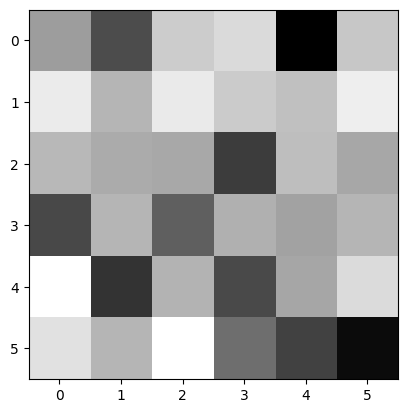

In [ ]:
weights=face_model.layers[0].get_weights()[0]
weights=weights.mean(axis=0).mean(axis=0).mean(axis=0)
reshaped_weights = weights.reshape(6,6)
reshaped_weights-=reshaped_weights.min()
reshaped_weights/=reshaped_weights.max()
plt.imshow(reshaped_weights, cmap='gray')



## NN from my data

In [8]:

## My data
import sys

if "google.colab" in sys.modules:
    path_to_files = os.sep.join([os.getcwd(), "BERN02---Computational-Science-Reproducible-Data-Science-and-Statistical-Learning","Exercise 8:NN"])
    !git clone https://github.com/myngoc-trg/BERN02---Computational-Science-Reproducible-Data-Science-and-Statistical-Learning.git --depth=1
else:
    path_to_files = os.sep.join([os.getcwd(), "BERN02---Computational-Science-Reproducible-Data-Science-and-Statistical-Learning","Exercise 8:NN"])

Cloning into 'BERN02---Computational-Science-Reproducible-Data-Science-and-Statistical-Learning'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 132 (delta 1), reused 114 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (132/132), 109.44 MiB | 20.27 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [9]:
import os
os.listdir("/content")


['.config',
 'Bern02',
 'BERN02---Computational-Science-Reproducible-Data-Science-and-Statistical-Learning',
 'sample_data']

In [11]:
from PIL import Image
!pip install pillow-heif
import pillow_heif

pillow_heif.register_heif_opener()
data=[]
list_of_files=os.listdir(os.sep.join([path_to_files,'Data']))
for filename in sorted(list_of_files):
    data.append(np.array(Image.open(os.sep.join([path_to_files,'Data',filename])).convert("RGB")))






   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.2 MB/s eta 0:00:00


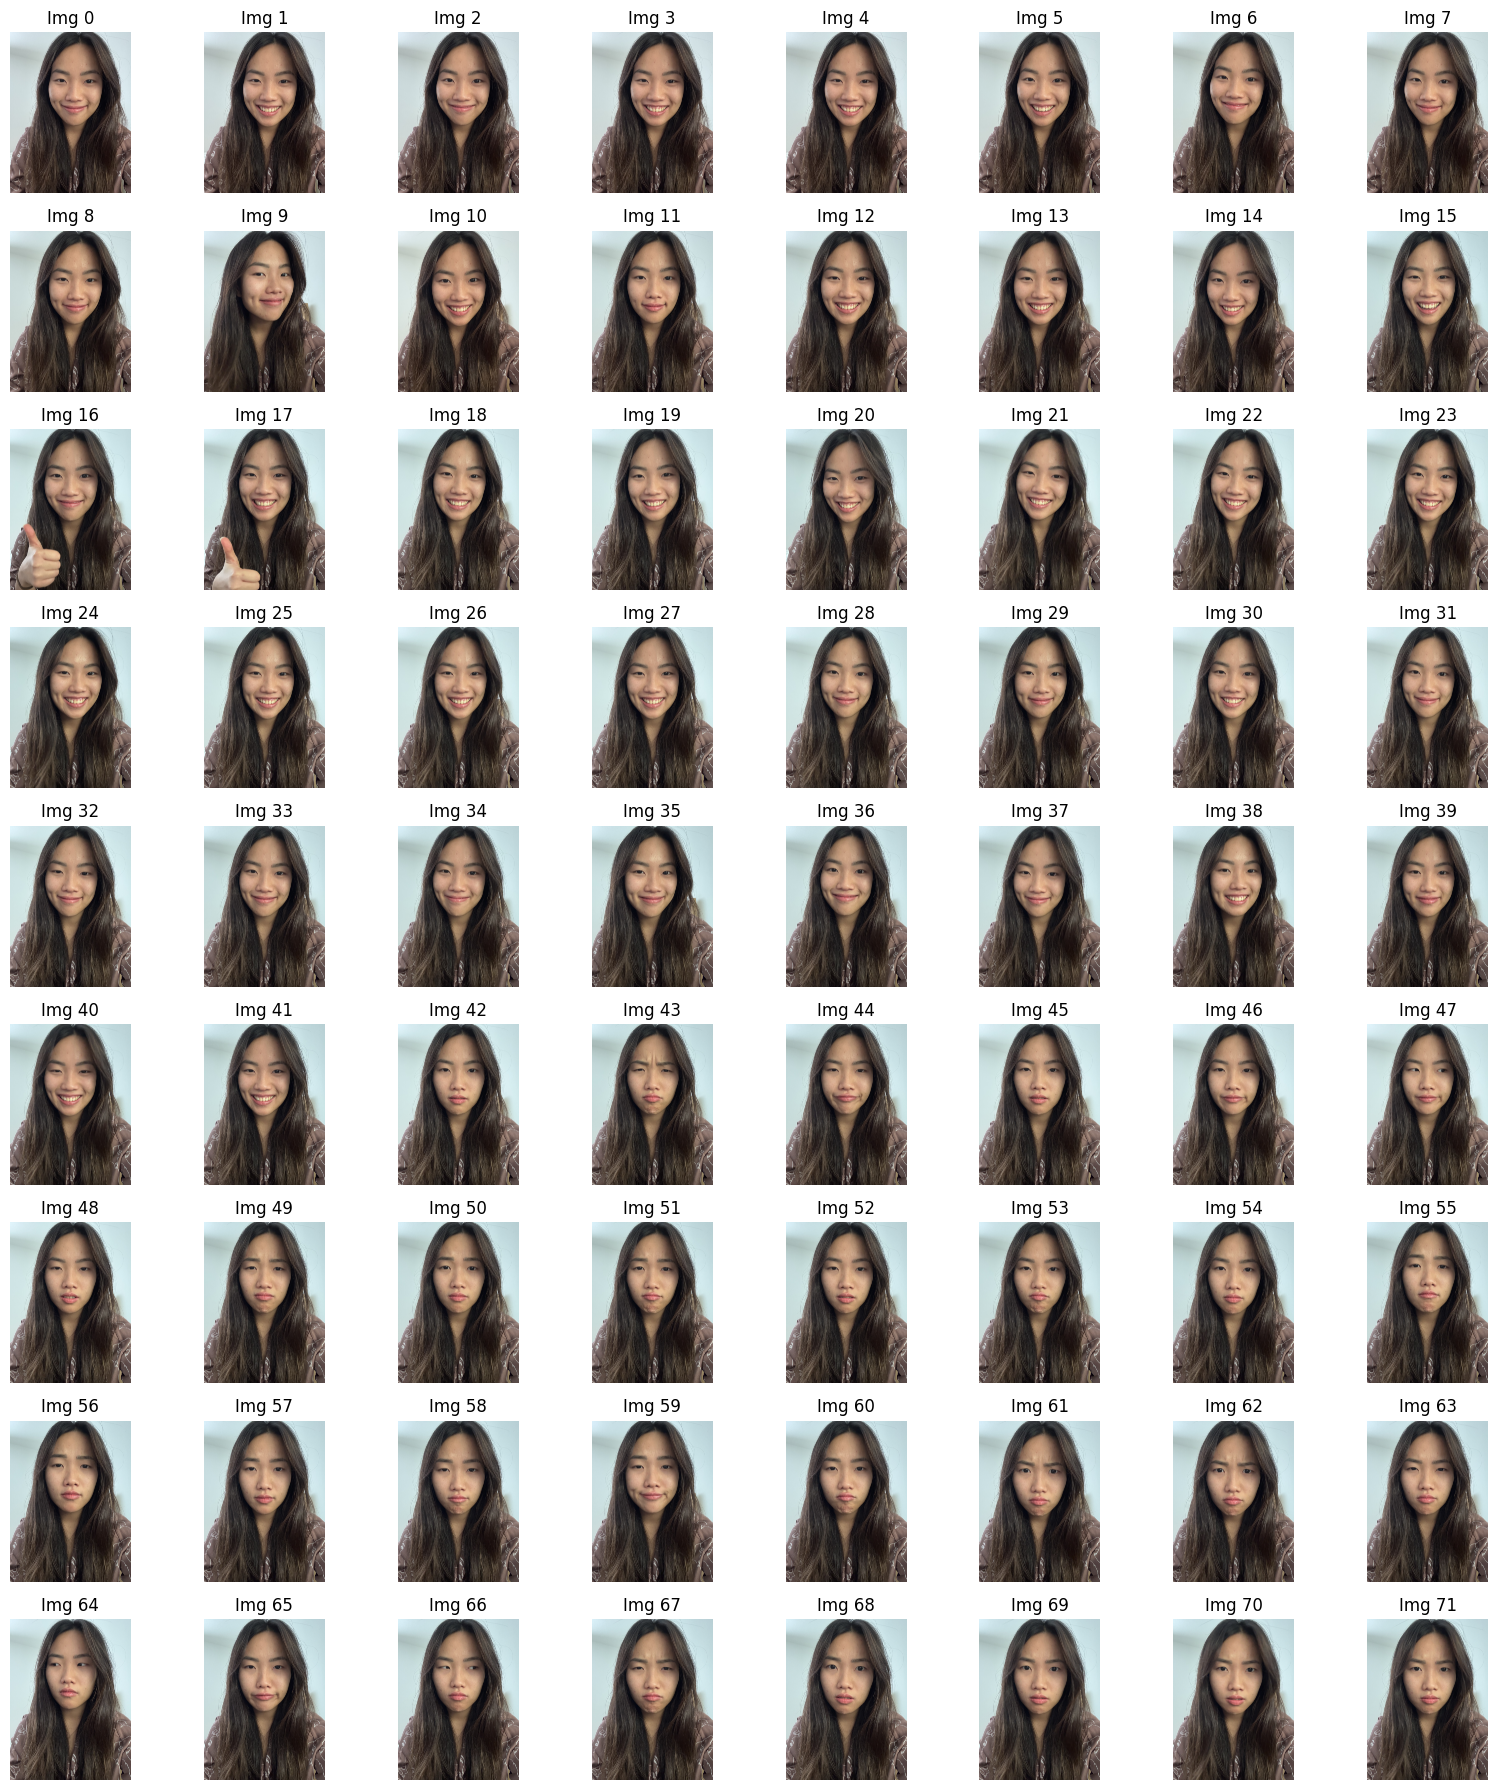

In [12]:

num_rows = 9
num_cols = 8
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 18))

# Flatten axes for easy indexing
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(data):
        ax.imshow(data[i], cmap='gray')  # grayscale images
        ax.set_title(f"Img {i}")
    ax.axis('off')  # remove axis ticks

plt.tight_layout()
plt.show()


In [13]:
happy = np.array([1]*42 + [0]*35)
print(happy)
print(happy.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
(77,)


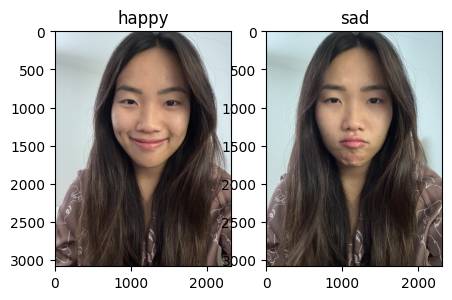

In [14]:
plt.figure(figsize=[5,5])
def naming(key):
    if key==1:return 'happy'
    elif key==0: return 'sad'
    else: raise
# Display the first image in training data
happy_idx = 0
sad_idx = 60
plt.subplot(121)
plt.imshow(data[happy_idx])
plt.title("{}".format(naming(happy[happy_idx])))
# Display the first image in testing data
plt.subplot(122)
plt.imshow(data[sad_idx])
plt.title("{}".format(naming(happy[sad_idx])))
plt.show()

In [15]:

data=[cv2.resize(img[400:1900,600:1900,:].mean(axis=2)/255,dsize=(36,36)) for img in data]
data=np.array(data)
label=np.vstack((happy,np.negative(happy)+1)).T

In [16]:
label

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0,

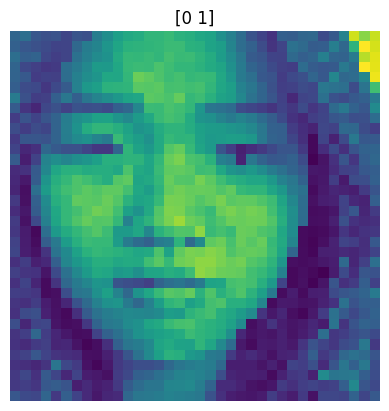

In [17]:
import matplotlib.pyplot as plt

plt.imshow(data[50])   # show first image
plt.title(label[50])
plt.axis('off')
plt.show()


In [30]:
train_x,test_x,train_label,test_label = train_test_split(data, label, test_size=0.2, random_state=13)
# test the shape
train_x.shape,test_x.shape,train_label.shape,test_label.shape

((61, 36, 36), (16, 36, 36), (61, 2), (16, 2))

In [31]:
train_x,valid_x,train_label,valid_label = train_test_split(train_x, train_label, test_size=0.2, random_state=13)
# test the shape
train_x.shape,valid_x.shape,train_label.shape,valid_label.shape

((48, 36, 36), (13, 36, 36), (48, 2), (13, 2))

In [32]:
train_label[0]

array([1, 0])

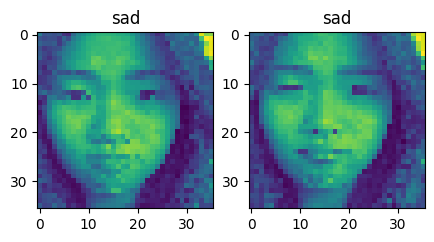

In [33]:
plt.figure(figsize=[5,5])
def naming(key):
    if np.array_equal(key, [1, 0]):return 'happy'
    elif np.array_equal(key, [0,1]): return 'sad'
    else: raise
# Display the first image in training data
happy_idx1 = 6
happy_idx2 = 5
plt.subplot(121)
plt.imshow(train_x[happy_idx1,:,:])
plt.title("{}".format(naming(train_label[happy_idx1])))
# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_x[happy_idx2,:,:])
plt.title("{}".format(naming(test_label[happy_idx2])))
plt.show()

In [34]:
# HYPER-PARAMETERS
batch_size = 8 # load this many
epochs = 50     # Total throughput
num_classes = 2 # Categories

face_model0 = Sequential()
face_model0.add(Conv2D(36, kernel_size=(3,3), activation='linear', input_shape=(36,36,1), padding='same'))
face_model0.add(LeakyReLU(0.1))
face_model0.add(Conv2D(72,(1,1), activation='linear', padding='same'))
face_model0.add(LeakyReLU(0.1))
face_model0.add(Flatten())
face_model0.add(Dense(num_classes, activation='softmax'))
face_model0.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
face_model0.summary()
face_train0 = face_model0.fit(train_x, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_x, valid_label))
face_model0.save("face_model0.h5")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 36, 36, 36)     │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 36, 36, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 36, 36, 72)     │         2,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 36, 36, 72)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │       186,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,650 (740.82 KB)

 Trainable params: 189,650 (740.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.4866 - loss: 0.8464 - val_accuracy: 0.7692 - val_loss: 0.5640
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7042 - loss: 0.6148 - val_accuracy: 0.6154 - val_loss: 0.5032
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7128 - loss: 0.4275 - val_accuracy: 0.8462 - val_loss: 0.3910
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9411 - loss: 0.2834 - val_accuracy: 0.7692 - val_loss: 0.3645
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9283 - loss: 0.2538 - val_accuracy: 0.7692 - val_loss: 0.2971
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9801 - loss: 0.1300 - val_accuracy: 0.7692 - val_loss: 0.2839
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9625 - loss: 0.1113 - val_accuracy: 0.9231 - val_loss: 0.2517
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9244 - loss: 0.1447 - val_accuracy: 0.8462 - val_loss: 0.2178

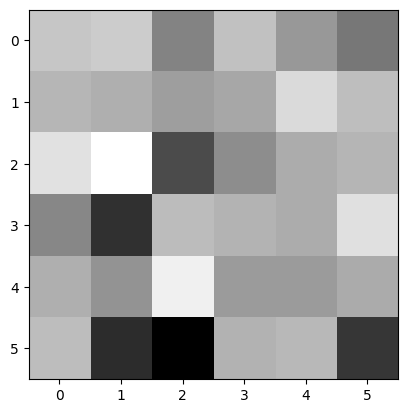

In [35]:
weights=face_model0.layers[0].get_weights()[0]
weights=weights.mean(axis=0).mean(axis=0).mean(axis=0)
reshaped_weights = weights.reshape(6,6)
reshaped_weights-=reshaped_weights.min()
reshaped_weights/=reshaped_weights.max()
plt.imshow(reshaped_weights, cmap='gray')



Test loss: 0.13176213204860687
Test accuracy: 0.9375


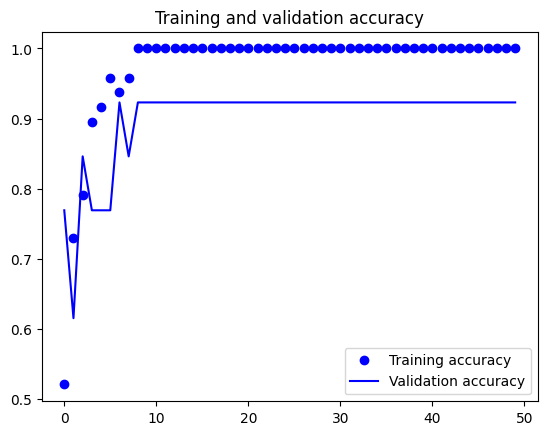

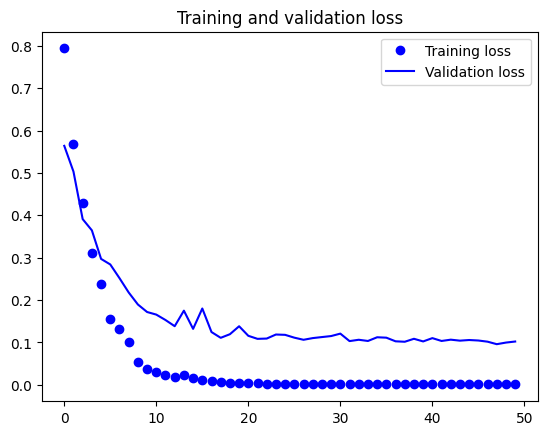

In [36]:
test_eval = face_model0.evaluate(test_x, test_label, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = face_train0.history['accuracy']
val_accuracy = face_train0.history['val_accuracy']
loss = face_train0.history['loss']
val_loss = face_train0.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [37]:
test_label, np.argmax(test_label, axis=1)

(array([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]]),
 array([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Found 15 correct recognitions (of 16 total)


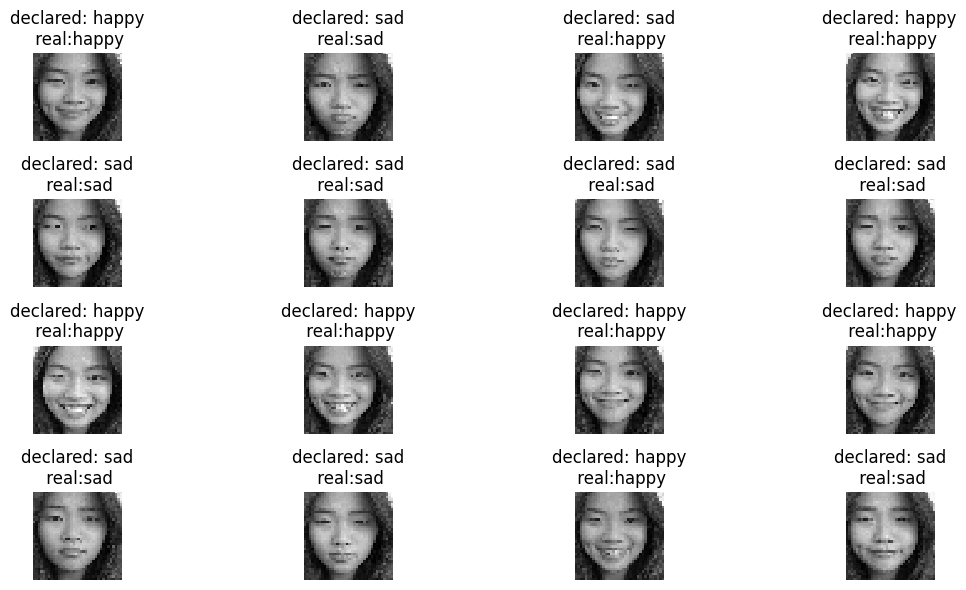

In [38]:
def naming(key):
    if isinstance(key, np.ndarray):
        if np.array_equal(key, [1, 0]): return 'happy'
        elif np.array_equal(key, [0, 1]): return 'sad'
        else: raise
    elif isinstance(key, (int, np.integer)):
        if key == 1: return 'happy'
        elif key == 0: return 'sad'
        else: raise
    else:
        raise
predicted_classes = face_model0.predict(test_x)
predicted_classes = 1-np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_x.shape
test_labels = 1-np.argmax(test_label, axis=1)
correct = np.where(predicted_classes==test_labels)[0]
print("Found %d correct recognitions (of %d total)"%(len(correct),len(test_label)))
fig,ax=plt.subplots(4,4,figsize=(12,6))
ax=ax.ravel()
for i in range(len(test_x)):
    ax[i].imshow(test_x[i].reshape(36,36), cmap='gray', interpolation='none')
    ax[i].set_title("declared: %s\n real:%s"%(naming(predicted_classes[i]),naming(test_labels[i])))
    ax[i].axis('off')
fig.tight_layout()

In [39]:
# HYPER-PARAMETERS
batch_size = 8 # load this many
epochs = 50     # Total throughput
num_classes = 2 # Categories

face_model1 = Sequential()
face_model1.add(Conv2D(36, kernel_size=(3,3), activation='linear', input_shape=(36,36,1), padding='same'))
face_model1.add(LeakyReLU(0.1))
face_model1.add(MaxPooling2D((2,2), padding='same'))
face_model1.add(Conv2D(64,(1,1), activation='linear', padding='same'))
face_model1.add(LeakyReLU(0.1))
face_model1.add(MaxPooling2D((2,2), padding='same'))
face_model1.add(Flatten())
face_model1.add(Dense(num_classes, activation='softmax'))
face_model1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
face_model1.summary()
face_train1 = face_model1.fit(train_x, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_x, valid_label))
face_model1.save("face_model1.h5")


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 36, 36, 36)     │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 36, 36, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 18, 18, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 18, 18, 64)     │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │        10,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 13,098 (51.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.5738 - loss: 0.6844 - val_accuracy: 0.6154 - val_loss: 0.6333
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5208 - loss: 0.6668 - val_accuracy: 0.7692 - val_loss: 0.6187
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8601 - loss: 0.6269 - val_accuracy: 0.6154 - val_loss: 0.5796
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6887 - loss: 0.6017 - val_accuracy: 0.8462 - val_loss: 0.5599
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9092 - loss: 0.5529 - val_accuracy: 0.7692 - val_loss: 0.5176
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8393 - loss: 0.5328 - val_accuracy: 0.7692 - val_loss: 0.4876
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8872 - loss: 0.4864 - val_accuracy: 0.6923 - val_loss: 0.4862
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8512 - loss: 0.4397 - val_accuracy: 0.7692 - val_loss: 0.4613

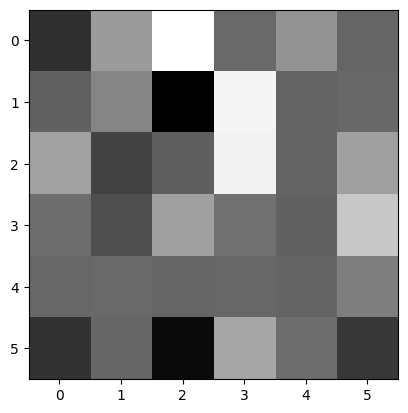

In [40]:
weights=face_model1.layers[0].get_weights()[0]
weights=weights.mean(axis=0).mean(axis=0).mean(axis=0)
reshaped_weights = weights.reshape(6,6)
reshaped_weights-=reshaped_weights.min()
reshaped_weights/=reshaped_weights.max()
plt.imshow(reshaped_weights, cmap='gray')



Test loss: 0.059418998658657074
Test accuracy: 1.0


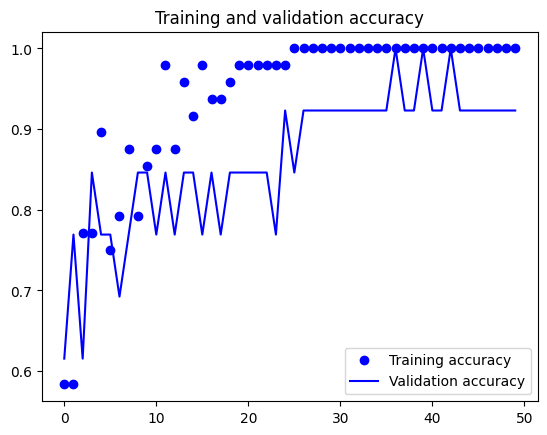

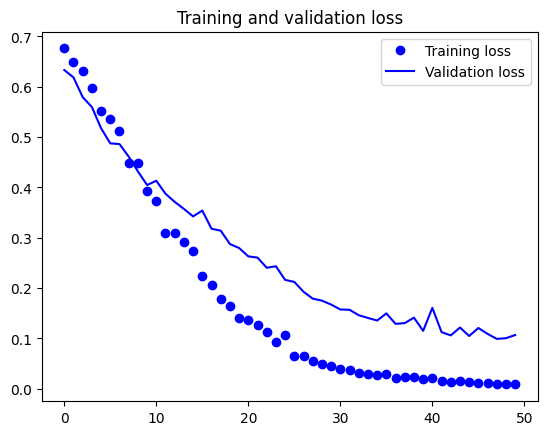

In [41]:
test_eval = face_model1.evaluate(test_x, test_label, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = face_train1.history['accuracy']
val_accuracy = face_train1.history['val_accuracy']
loss = face_train1.history['loss']
val_loss = face_train1.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Found 16 correct recognitions (of 16 total)


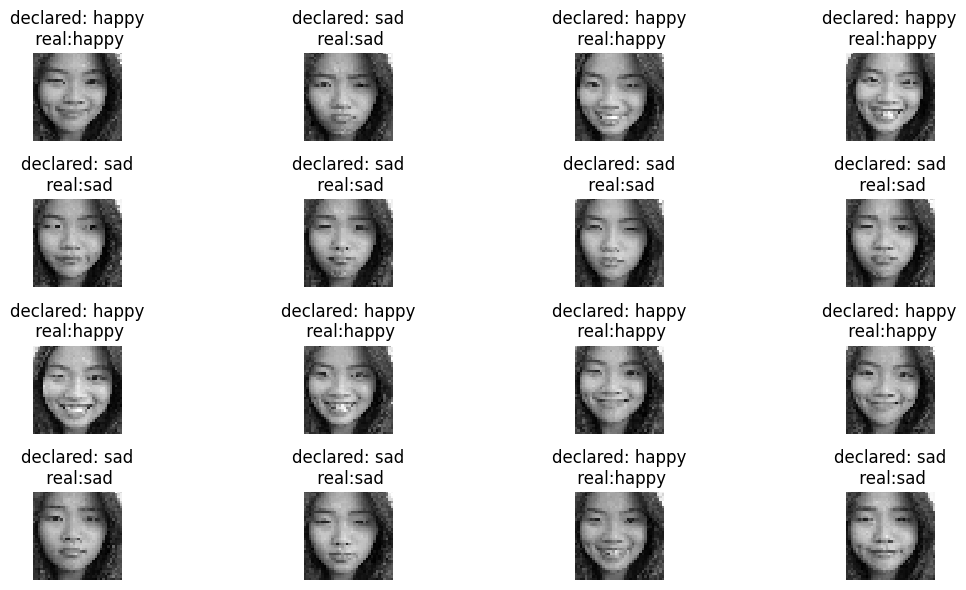

In [42]:
def naming(key):
    if isinstance(key, np.ndarray):
        if np.array_equal(key, [1, 0]): return 'happy'
        elif np.array_equal(key, [0, 1]): return 'sad'
        else: raise
    elif isinstance(key, (int, np.integer)):
        if key == 1: return 'happy'
        elif key == 0: return 'sad'
        else: raise
    else:
        raise
predicted_classes = face_model1.predict(test_x)
predicted_classes = 1-np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_x.shape
test_labels = 1-np.argmax(test_label, axis=1)
correct = np.where(predicted_classes==test_labels)[0]
print("Found %d correct recognitions (of %d total)"%(len(correct),len(test_label)))
fig,ax=plt.subplots(4,4,figsize=(12,6))
ax=ax.ravel()
for i in range(len(test_x)):
    ax[i].imshow(test_x[i].reshape(36,36), cmap='gray', interpolation='none')
    ax[i].set_title("declared: %s\n real:%s"%(naming(predicted_classes[i]),naming(test_labels[i])))
    ax[i].axis('off')
fig.tight_layout()

## Task
Apply the learning and verification on the MNIST dataset.
1. Start by looking at the data and verify the shape.
2. Then adapt the code to work with this classical dataset.

x_train: uint8 NumPy array of grayscale image data with shapes (60000, 28, 28), containing the training data. Pixel values range from 0 to 255.

y_train: uint8 NumPy array of digit labels (integers in range 0-9) with shape (60000,) for the training data.

x_test: uint8 NumPy array of grayscale image data with shapes (10000, 28, 28), containing the test data. Pixel values range from 0 to 255.

y_test: uint8 NumPy array of digit labels (integers in range 0-9) with shape (10000,) for the test data.

In [43]:
import keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))